In [68]:
import numpy as np
import pandas as pd
from pyproj import Transformer
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN, KMeans, AffinityPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

In [10]:
cat1 = pd.read_csv('10950_2019_9864_MOESM2_ESM.csv')
cat2 = pd.read_csv('SRL_2017007_esupp_matched_filter_cat_pawnee.csv',delimiter="\t")

# filter out everything except Pawnee
cat1 = cat1[(cat1['lat']>36.3) & (cat1['lat']<36.6) & (cat1['long']<-96.75) & (cat1['long']>-97.1)]

In [11]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
cat1[['x', 'y']] = cat1.apply(
    lambda row: transformer.transform(row['long'], row['lat']), axis=1, result_type='expand'
)
cat2[['x', 'y']] = cat2.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

df = cat1
df.drop_duplicates()

,year,month,day,hour,minute,second,lat,long,depth,mag,x,y
18451,2011,12,18,9,32,7.82,36.38122,-96.93248,2.487,1.41632,-1.079047e+07,4.353204e+06
18457,2011,12,18,11,35,10.45,36.38122,-96.93248,2.487,1.45126,-1.079047e+07,4.353204e+06
18463,2011,12,18,21,43,24.34,36.38122,-96.93248,2.487,1.56777,-1.079047e+07,4.353204e+06
18793,2011,12,25,11,11,49.92,36.38122,-96.93248,2.487,1.49907,-1.079047e+07,4.353204e+06
20070,2012,2,20,22,7,14.93,36.42580,-96.90948,5.126,3.11846,-1.078791e+07,4.359370e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
209384,2016,12,30,18,47,13.17,36.44808,-96.88112,5.477,1.74957,-1.078476e+07,4.362453e+06
209387,2016,12,30,19,20,21.15,36.44872,-96.87959,8.014,2.18439,-1.078459e+07,4.362542e+06
209390,2016,12,30,19,45,13.42,36.43382,-96.90550,4.680,2.17865,-1.078747e+07,4.360480e+06
209404,2016,12,30,22,0,25.84,36.43382,-96.90550,4.680,1.88090,-1.078747e+07,4.360480e+06


In [71]:
# Outlier removal
z_thres = 3.0
z_scores = (df - df.mean())/df.std()
outliers = (z_scores.abs() > z_thres).any(axis=1)
df_cleaned = df[~outliers]

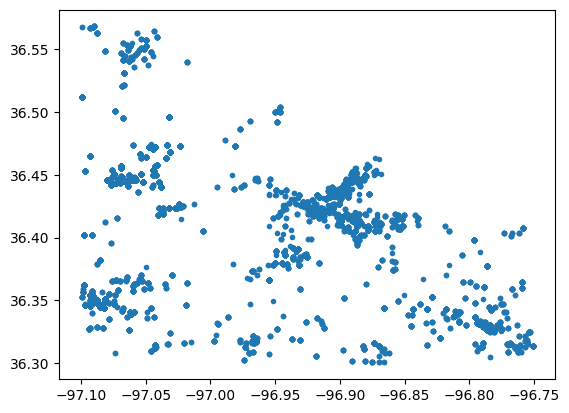

C:\Users\archo\AppData\Local\Temp\ipykernel_2124\4066123184.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = cluster_labels


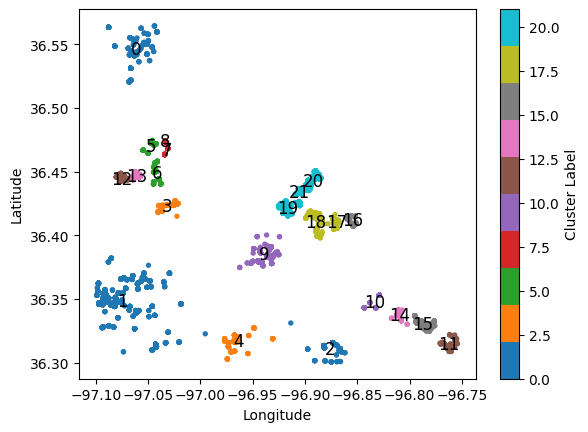

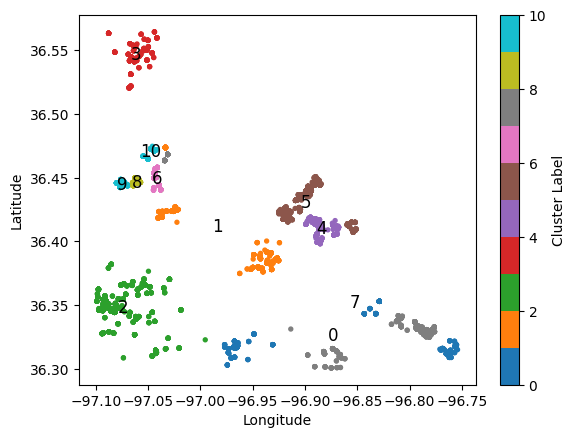

In [ ]:
# HDBSCAN and KNN clustering

# plot xy
plt.plot(df_cleaned['long'],df_cleaned['lat'],'.')
plt.show()

X = df_cleaned[['lat','long']]

method = "hdb" # <---------------------------- CHANGE THIS TO USE DIFFERENT CLUSTERING METHOD
if method == "hdb":
    hdb = HDBSCAN(min_cluster_size=80)
    cluster_labels = hdb.fit_predict(X)
elif method=="kmn":
    kmeans = KMeans(n_clusters=10)
    cluster_labels = kmeans.fit_predict(X)
elif method=="afp":
    affinityp = AffinityPropagation()
    cluster_labels = affinityp.fit_predict(X)
mask = cluster_labels!=-1

include_noise = False # <---------------------- CHANGE THIS TO INCLUDE ALL EARTHQUAKES

if include_noise:
    X_train = X[mask]
    y_train = cluster_labels[mask]
    X_noise = X[not mask]

    knn = KNeighborsClassifier(n_neighbors=80)
    knn.fit(X_train, y_train)

    if not X_noise.empty:
        noise_labels = knn.predict(X_noise)
        cluster_labels[not mask] = noise_labels

df_cleaned['cluster'] = cluster_labels

df_cleaned = df_cleaned[df_cleaned['cluster']!=-1]
centroids = df_cleaned.groupby('cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#merging clusters

for new_label, group in enumerate(groups):
    for old_label in group:
        cluster_mapping[old_label] = new_label

df_cleaned['merged_cluster'] = df_cleaned['cluster'].map(cluster_mapping)


centroids = df_cleaned.groupby('merged_cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['merged_cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

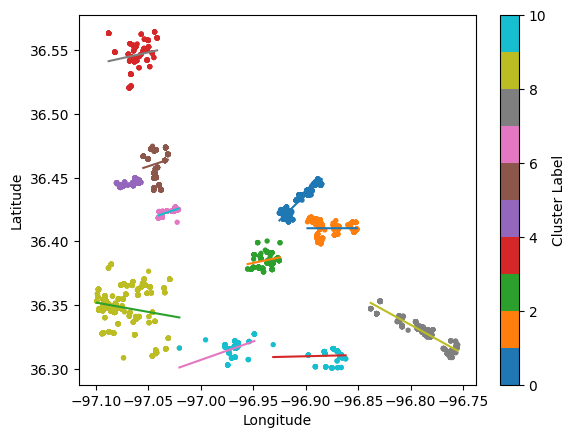

In [70]:
# Best fits
cluster_type = "merged_cluster"
for cluster in df_cleaned[cluster_type].unique():
    cluster_data = df_cleaned[df_cleaned[cluster_type] == cluster]
    X = cluster_data['long'].values.reshape(-1, 1)
    y = cluster_data['lat'].values
    model = LinearRegression()
    model.fit(X, y)

    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_vals = model.predict(x_vals)
    plt.plot(x_vals, y_vals, label=f'Cluster {cluster} Line')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['merged_cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
